# AMOS 2024 - Accessing and using BARRA2 and BARPA data for research at NCI

AUTHOR: Joshua Torrance (joshua.torrance@bom.gov.au) & Rui Yang (rui.yang@anu.edu.au)

#### AMOS 2024 Workshop Landing Page 

https://opus.nci.org.au/display/DAE/AMOS+2024+Workshop%3A++Accessing+and+using+BARRA2+and+BARPA+data+for+research

## BARRA2

Bureau of Meteorology Atmospheric high-resolution Regional Reanalysis for 
Australia - Version 2 (BARRA2) is a reanalysis from 1979 to the present day covering Australia, New Zealand and a portion of South-East Asia.

NCI Data Catalogue: https://doi.org/10.25914/1x6g-2v48

Extended Documentation: https://opus.nci.org.au/x/DgDADw

## BARPA

The Bureau of Meteorology Atmospheric Regional Projections for Australia (BARPA) delivers high-resolution dynamical downscaling of CMIP6 experiments over CORDEX-Australasia and Australian domains.

NCI Data Catalogue: https://doi.org/10.25914/z1x6-dq28

Extended Documentation: https://opus.nci.org.au/x/CQDADw

## Accessing BARRA2 & BARPA

The outputs for BARRA2 and BARPA are store at NCI in the ob53 and py18 projects respectively.
Access to these projects can be requested in the usual way at the NCI account management pages - https://my.nci.org.au/mancini
The files are also available for direct download from NCI's Thredds server:
- [BARRA2](https://dap.nci.org.au/thredds/remoteCatalogService?catalog=https://dapds00.nci.org.au/thredds/catalogs/ob53/catalog.xml)
- [BARPA](https://dap.nci.org.au/thredds/remoteCatalogService?catalog=https://dapds00.nci.org.au/thredds/catalogs/py18/catalog.xml)

### List of variables

A list of the variables used by BARPA and BARRA2 can be found [here](https://github.com/joshuatorrance/barpa-barra2-amos2024/blob/main/BARRA2_BARPA_variable_list.csv).

***
This notebook covers some basic interactions with BARPA and BARRA2 data and some simple manipulations using *xarray*.

For more information on the multitude of tools available with *xarray* check out the xarray documentation:
https://docs.xarray.dev/en/stable/getting-started-guide/index.html
***

## Enter the notebook directory

To begin, navigate to the directory containing this notebook. The 'nci_ipynb' package, developed by NCI, is designed to automate this process. 
For more details, please refer https://pypi.org/project/nci-ipynb

In [1]:
import os
import nci_ipynb

os.chdir(nci_ipynb.dir())
print(os.getcwd())

/scratch/om02/jt4085/barpa-barra2-amos2024


First we load the required python modules and start a dask client to speed up our computation.

In [2]:
# Imports for the notebook
import os, sys
from glob import glob
from datetime import datetime
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import cartopy.crs
import dask.distributed

Let's explictly load dask so we can check progress

In [3]:
# Copy and paste the dashboard link/path from this cell's output
# to the Dask tab on the left.
client = dask.distributed.Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37105,Workers: 2
Dashboard: /proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:45769,Total threads: 1
Dashboard: /proxy/46243/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:35965,


There should now be a dask client running (click on "Launch dashboard in JupyterLab" to see the dashboard). The dask client will allow for better parallelisation of xarray operations such as opens multiple files or processing large datasets.

You can see the progress of dask operations in the dask dashboard.

## 1. Loading BARRA2/BARPA data - the basic way

We will build a path to the BARRA2 data manually.

In [4]:
## Data location
# Let's define the path to the files we're interested in
# BARRA2
source_id = 'BARRA-R2'
domain_id = 'AUS-11'   # Domain of BARRA-R2, in native grid 0.11deg
RCM_institution_id = 'BOM'  
driving_source_id = 'ERA5'  # Driving global model
driving_experiment_id = 'historical'  
driving_variant_label = 'hres'   # Using ERA5 HRES analysis

barra2_top_path = "/g/data/ob53/BARRA2/output/reanalysis/"

barra_r2_root_path = f"{barra2_top_path}/{domain_id}/{RCM_institution_id}/" + \
        f"{driving_source_id}/{driving_experiment_id}/{driving_variant_label}/{source_id}/v1"

In [5]:
! ls $barra_r2_root_path

1hr  3hr  day  fx  mon


Similarly we can also build a path to the BARPA data.

In [6]:
## Data location
# BARPA
source_id = 'BARPA-R'
domain_id = 'AUS-15'   # Domain of BARPA-R, in native grid 0.154deg
RCM_institution_id = 'BOM'  
# Driving CMIP6 model from ACCESS-CM2, ACCESS-ESM1-5, CESM2, CMCC-ESM2, EC-Earth3, MPI-ESM1-2-HR, NorESM2-MM
# Or ERA5 (evaluation)
driving_source_id = 'ACCESS-CM2' 
driving_experiment_id = 'historical'  #  CMIP6 scenarios: historical, ssp370, ssp126
driving_variant_label = 'r4i1p1f1'  # CMIP6 model ensemble member

barpa_top_path = "/g/data/py18/BARPA/output/CMIP6/DD/"

barpa_r_root_path = f"{barpa_top_path}/{domain_id}/{RCM_institution_id}/" + \
        f"{driving_source_id}/{driving_experiment_id}/{driving_variant_label}/{source_id}/v1-r1"

In [7]:
! ls $barpa_r_root_path

1hr  6hr  day  fx  mon


Next we specify the variable, and time period

In [8]:
### Pick the root path that interests you, either BARPA or BARRA2, comment out the other one. ###
root_path = barra_r2_root_path
# root_path = barpa_r_root_path

## freq - Time resolution of the data
# e.g. BARRA - mon, day, 3hr, 1hr
#      BARPA - mon, day, 6hr, 1hr
freq = "1hr"

## variable_id
# Choose the variable to look at, e.g. "ts" for surface temperature
variable_id = "ts"

## Date (YYYYMM)
# With glob we can use wild cards to find the files we want
# e.g. "2014??" for all of 2014 or "20140[123]" for the first three months
# Note that BARRA2 data has one file per month, BARPA data has one file per year
date = "2014??"

# Build a string to use with glob
glob_str = os.path.join(root_path, freq, variable_id, "*", f"*{date}.nc")

# Pass the string to glob will will return a matching list of file paths
file_list = sorted(glob(glob_str))

In [9]:
print("\n".join(file_list))

/g/data/ob53/BARRA2/output/reanalysis//AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/ts/v20231001/ts_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_201401-201401.nc
/g/data/ob53/BARRA2/output/reanalysis//AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/ts/v20231001/ts_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_201402-201402.nc
/g/data/ob53/BARRA2/output/reanalysis//AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/ts/v20231001/ts_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_201403-201403.nc
/g/data/ob53/BARRA2/output/reanalysis//AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/ts/v20231001/ts_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_201404-201404.nc
/g/data/ob53/BARRA2/output/reanalysis//AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/ts/v20231001/ts_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_201405-201405.nc
/g/data/ob53/BARRA2/output/reanalysis//AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/ts/v20231001/ts_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_201406-20

Now that we have the file paths, open the dataset using xarray

In [10]:
# If we have a single file we can use open_dataset
#ds = xr.open_dataset(file_list[0])

# If we have a list of files we use open_mfdataset
# Use parallel=True to take advantage of Dask's multiprocessing
ds = xr.open_mfdataset(file_list, parallel=True)

# Quick look
ds

<xarray.Dataset>
Dimensions:  (time: 8760, lat: 646, lon: 1082)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
  * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
Data variables:
    ts       (time, lat, lon) float64 dask.array<chunksize=(16, 98, 165), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

In [11]:
# More information about this variable and data
ds[variable_id].attrs

{'long_name': 'Surface Temperature',
 'standard_name': 'surface_temperature',
 'units': 'K',
 'cell_methods': 'time: point (interval: 1H)'}

## 2. Loading BARRA2/BARPA data with Intake-ESM

Instead of constructing the file paths by hand, you can use NCI Intake-ESM catalog files to manipulate BARRA2/BARPA data collections.

For more details in NCI indexing scheme, please refer https://opus.nci.org.au/display/DAE/Analysing+data+using+intake+indexes

In [12]:
import intake

# Specify the Intake-esm catalog files.
catalog_files = {"BARPA":"/g/data/dk92/catalog/v2/esm/barpa-py18/catalog.json",
                "BARRA2":"/g/data/dk92/catalog/v2/esm/barra2-ob53/catalog.json"}

# Choose the collection name
collection_name = "BARRA2" # BARPA

# Read in the catalogue which we will later use to interrogate the content
data_catalog = intake.open_esm_datastore(catalog_files[collection_name])

/opt/conda/envs/datasci/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


Next, we interrogate the catalogue using keys

But what are the keys?  
(We have already encountered before!)

In [13]:
list(data_catalog.df.keys())

['path',
 'file_type',
 'project_id',
 'activity_id',
 'domain_id',
 'RCM_institution_id',
 'driving_source_id',
 'driving_experiment_id',
 'driving_variant_label',
 'source_id',
 'version_realisation',
 'freq',
 'variable_id',
 'version',
 'start_time',
 'end_time',
 'time_range']

We can search the catalogue based on a group of identifier keys.

In [14]:
# In this example, we query for a listing of all the 
#     one-hourly "ts" (surface temperature) during 2014

# Set up the query
query = dict(
    variable_id=["ts"],
    time_range=["2014/*"],
    freq=["1hr"],
)

# perform the search
catalog_subset = data_catalog.search(**query)

# The information from the searched catalog object could be viewed in a pandas table.
print(catalog_subset.df)

                                                 path file_type project_id  \
0   /g/data/ob53/BARRA2/output/reanalysis/AUS-11/B...         f     output   
1   /g/data/ob53/BARRA2/output/reanalysis/AUS-11/B...         f     output   
2   /g/data/ob53/BARRA2/output/reanalysis/AUS-11/B...         f     output   
3   /g/data/ob53/BARRA2/output/reanalysis/AUS-11/B...         f     output   
4   /g/data/ob53/BARRA2/output/reanalysis/AUS-11/B...         f     output   
5   /g/data/ob53/BARRA2/output/reanalysis/AUS-11/B...         f     output   
6   /g/data/ob53/BARRA2/output/reanalysis/AUS-11/B...         f     output   
7   /g/data/ob53/BARRA2/output/reanalysis/AUS-11/B...         f     output   
8   /g/data/ob53/BARRA2/output/reanalysis/AUS-11/B...         f     output   
9   /g/data/ob53/BARRA2/output/reanalysis/AUS-11/B...         f     output   
10  /g/data/ob53/BARRA2/output/reanalysis/AUS-11/B...         f     output   
11  /g/data/ob53/BARRA2/output/reanalysis/AUS-11/B...         f 

/opt/conda/envs/datasci/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/opt/conda/envs/datasci/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


In [15]:
# You could also set keywords when loading the dataset.
dsets = catalog_subset.to_dataset_dict(
#    xarray_open_kwargs={'chunks':{'lat': 646, 'lon': 1082, 'time': 'auto'}}
)
dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_type.project_id.activity_id.domain_id.RCM_institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realisation.freq.variable_id.version'


{'f.output.reanalysis.AUS-11.BOM.ERA5.historical.hres.BARRA-R2.v1.1hr.ts.v20231001': <xarray.Dataset>
 Dimensions:  (time: 8760, lat: 646, lon: 1082)
 Coordinates:
   * time     (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
   * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
   * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
 Data variables:
     ts       (time, lat, lon) float64 dask.array<chunksize=(16, 98, 165), meta=np.ndarray>
 Attributes: (12/66)
     axiom_version:                           0.1.0
     axiom_schemas_version:                   0.1.0
     axiom_schema:                            cordex-1H.json
     Conventions:                             CF-1.10, ACDD-1.3
     activity_id:                             reanalysis
     source:                                  Data from Met Office Unified Mod...
     ...                                      ...
     intake_esm_attrs:version_realisation:    v1
     intake

In [39]:
# You could also set keywords when loading the dataset.
dsets = catalog_subset.to_dataset_dict(
    xarray_open_kwargs={'chunks':{'lat': 646, 'lon': 1082, 'time': 'auto'}}
)
dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_type.project_id.activity_id.domain_id.RCM_institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realisation.freq.variable_id.version'


{'f.output.reanalysis.AUS-11.BOM.ERA5.historical.hres.BARRA-R2.v1.1hr.ts.v20231001': <xarray.Dataset>
 Dimensions:  (time: 8760, lat: 646, lon: 1082)
 Coordinates:
   * time     (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
   * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
   * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
 Data variables:
     ts       (time, lat, lon) float64 dask.array<chunksize=(16, 646, 1082), meta=np.ndarray>
 Attributes: (12/66)
     axiom_version:                           0.1.0
     axiom_schemas_version:                   0.1.0
     axiom_schema:                            cordex-1H.json
     Conventions:                             CF-1.10, ACDD-1.3
     activity_id:                             reanalysis
     source:                                  Data from Met Office Unified Mod...
     ...                                      ...
     intake_esm_attrs:version_realisation:    v1
     inta

## 3. Loading BARRA2/BARPA data using ESMLOADER

'esmloader' is a module included with these notebooks to simplify access to BARPA and BARRA2 datasets



In [17]:
import esmloader

# Specify the which data collection you want to load, i.e. BARRA2 or BARPA.
collection_name = "BARRA2"
barra2 = esmloader.EsmCat(collection_name)

/opt/conda/envs/datasci/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


In [18]:
help(barra2.load_barra2_data)

Help on method load_barra2_data in module esmloader:

load_barra2_data(source_id_in, freq_in, variable_id, version='*', tstart=19790101, tend=20300101, loc=None, latrange=None, lonrange=None, **read_kwargs) method of esmloader.EsmCat instance
    Returns the BARRA2 data
    
    Parameters:
       source_id_in (str): Model, e.g., BARRA-R2, BARRA-RE2, BARRA-C2
       freq_in (str): Time frequency of the data, e.g. 1hr, day, mon
       variable_id (str): Variable id, e.g., tas, uas, pr
       version (str): Data release version if multiple available
       tstart (integer): Start of the time range, in yyyymmddHH format
       tend (integer): End of the time range, in yyyymmddHH format
       loc (tuple of float), (latitude, longitude) if requesting data closest to a point location
       latrange (tuple of float), (latmin, latmax) if requesting data over a latitude range
       lonrange (tuple of float), (lonmin, lonmax) if requesting data over a longitude range
       read_kwargs (dict)

In [19]:
# Load some BARRA data
ds = barra2.load_barra2_data("BARRA-R2", "1hr", "ts", tstart=2014010100, tend=2015010100)
ds

/opt/conda/envs/datasci/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/opt/conda/envs/datasci/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


<xarray.Dataset>
Dimensions:  (time: 8761, lat: 646, lon: 1082)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-01-01T01:00:00 ... 2015-01-01
  * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
Data variables:
    ts       (time, lat, lon) float64 dask.array<chunksize=(16, 98, 165), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

In [20]:
barpa = esmloader.EsmCat("BARPA")

# Load some BARPA data
ds = barpa.load_barpa_data("BARPA-R", "ACCESS-CM2", "historical", "1hr", "ts", tstart=2014010100, tend=2014060100)
ds

/opt/conda/envs/datasci/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/opt/conda/envs/datasci/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/opt/conda/envs/datasci/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


<xarray.Dataset>
Dimensions:  (time: 3625, lat: 436, lon: 777)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-01-01T01:00:00 ... 2014-06-01
  * lat      (lat) float64 -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
  * lon      (lon) float64 88.04 88.19 88.34 88.5 ... 207.5 207.6 207.8 207.9
Data variables:
    ts       (time, lat, lon) float64 dask.array<chunksize=(82, 42, 76), meta=np.ndarray>
Attributes: (12/57)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               RCM
    title:                     Bureau of Meteorology Atmospheric Regional Pro...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science, Atmosphere; Continent, Australi...
    driving_experiment:        CSIRO-ARCCSS ACCESS-CM2; historical; r4i1p1f1
    driving_source_id:         ACCESS-CM2
    date_modified:             2023-11-16T17:10:01Z
    date_metadata_modified:    2023-11-16T17:10:01Z

### Load data contains some other helpful functions
Here's a couple of them

In [21]:
# Examine a particular variable
_ = barra2.whatis('1hr', 'pr')

/opt/conda/envs/datasci/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/opt/conda/envs/datasci/lib/python3.10/site-packages/intake_esm/cat.py:283: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


Short name: pr
long_name: Precipitation
standard_name: precipitation_flux
units: kg m-2 s-1
cell_methods: time: mean (interval: 1 hour)


In [22]:
# List the available variables
_ = barra2.list_barra2_variables('BARRA-R2', '1hr')

wa850, ta50m, clwvi, zg850, mrfsos, hus850, ta1000, va925, prsn, rlut, rlus, wa500, va200m, zg300, ua250m, clt, ua1000, ta400, wa300, va250m, omega500, hfls, rlutcs, clm, wa700, uas, ua50m, hus500, evspsblpot, va500, hus200, hus400, wa1000, ta300, zg200, ua100m, hus600, zg400, ta925, prw, zg600, ta850, clivi, ua700, uasmean, ua600, rldscs, ta950, vasmax, hus1000, va700, ua200m, rsds, zmla, ta200m, va300, wa400, ua200, ta700, zg1000, clh, ua500, va1000, rsdsdir, tasmin, vas, hus700, ta150m, CAPE, ua300, rsuscs, ua1500m, va600, hus950, hus925, rsdscs, pr, hfss, wa925, vasmean, rsut, cll, prc, ua150m, tasmax, ua400, ta600, va50m, ua850, sfcWind, hus300, wsgsmax, rsus, va1500m, ta500, rsutcs, tasmean, hurs, mrsos, psl, zg925, va200, zg700, va150m, huss, rlds, ua925, zg500, wa600, ta200, uasmax, va850, ta1500m, va400, ta100m, ts, rsdt, rluscs, va100m, CIN, ta250m, tas, ps, wa200


## Instantaneous vs. Accumulated variables
The variables used in BARPA and BARRA2 can be separated into two group, *instantaneous* and *accumulated*.

*Instantaneous* variables give a snapshot of the underlying model stat at the given time.

*Accumulated* variables give an aggregate view of a given time window (e.g. hourly mean, daily max). Accumulated variables will have an additional coordinate, 'time_bnds'. They use time values in the centre of their window, e.g., 00:30 for a 1h-averaged value between 00:00 to 01:00.

It's important to keep these different time values in mind if one if combining variables in some way, e.g. performing arithmetic or plotting.

More information on FAQ on BARRA2/BARPA Documentation: https://opus.nci.org.au/pages/viewpage.action?pageId=264241306

In [23]:
variable_id = 'tas'
freq = '1hr'

# What is this variable?
barra2.whatis(freq, variable_id)

# Take a look at the first time step
ds_inst = barra2.load_barra2_data("BARRA-R2", freq, variable_id, tstart=2014010100, tend=2015010100)
ds_inst['time'][0].data

Short name: tas
long_name: Near-Surface Air Temperature
standard_name: air_temperature
units: K
cell_methods: time: point (interval: 1H)


array('2014-01-01T00:00:00.000000000', dtype='datetime64[ns]')

In [24]:
variable_id = 'tasmax'
freq = '1hr'

# What is this variable?
barra2.whatis(freq, variable_id)

# Take a look at the first time step
ds_accum = barra2.load_barra2_data("BARRA-R2", freq, variable_id, tstart=2014010100, tend=2015010100)
ds_accum['time'][0].data

Short name: tasmax
long_name: Hourly Maximum Near-Surface Air Temperature
standard_name: air_temperature
units: K
cell_methods: time: maximum (interval: 1 hour)


array('2014-01-01T00:30:00.000000000', dtype='datetime64[ns]')

In [25]:
# Accumulated variables have time_bnds
ds_accum['time_bnds'][0:3].compute()

<xarray.DataArray 'time_bnds' (time: 3, bnds: 2)>
array([['2014-01-01T00:00:00.000000000', '2014-01-01T01:00:00.000000000'],
       ['2014-01-01T01:00:00.000000000', '2014-01-01T02:00:00.000000000'],
       ['2014-01-01T02:00:00.000000000', '2014-01-01T03:00:00.000000000']],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01T00:30:00 ... 2014-01-01T02:30:00
    height   float64 1.5
  * bnds     (bnds) float64 0.0 1.0

## Indexing and Plotting Data
Xarray has sophisticated indexing tools available.
There are many ways to index data with Xarray, below are a couple of examples.

See Xarray's [documentation](https://docs.xarray.dev/en/latest/user-guide/indexing.html) for more details.

Xarray data sets can be easily plotting with matplotlib.

In [26]:
variable_id = 'ts'
ds = barra2.load_barra2_data("BARRA-R2", "1hr", variable_id, tstart=2014010100, tend=2015010100)
ds

<xarray.Dataset>
Dimensions:  (time: 8761, lat: 646, lon: 1082)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-01-01T01:00:00 ... 2015-01-01
  * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
Data variables:
    ts       (time, lat, lon) float64 dask.array<chunksize=(16, 98, 165), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

### First timestep

In [27]:
# Select the first timestep using the index
ds_first_timestep = ds.isel(time=0)
ds_first_timestep

<xarray.Dataset>
Dimensions:  (lat: 646, lon: 1082)
Coordinates:
    time     datetime64[ns] 2014-01-01
  * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
Data variables:
    ts       (lat, lon) float64 dask.array<chunksize=(98, 165), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

In [28]:
# Alternatively select the first timestep by giving a string
# Look what happens if we don't specify said string precisely
ds.sel(time='2014-01-01')

<xarray.Dataset>
Dimensions:  (time: 24, lat: 646, lon: 1082)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 ... 2014-01-01T23:00:00
  * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
Data variables:
    ts       (time, lat, lon) float64 dask.array<chunksize=(16, 98, 165), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

In [29]:
# Select the first timestep by giving a precise string
ds_first_timestep = ds.sel(time='2014-01-01T00:00')
ds_first_timestep

<xarray.Dataset>
Dimensions:  (lat: 646, lon: 1082)
Coordinates:
    time     datetime64[ns] 2014-01-01
  * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
Data variables:
    ts       (lat, lon) float64 dask.array<chunksize=(98, 165), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

### Basic Plotting
xarray uses matplotlib to allow for quick and convenient plotting.

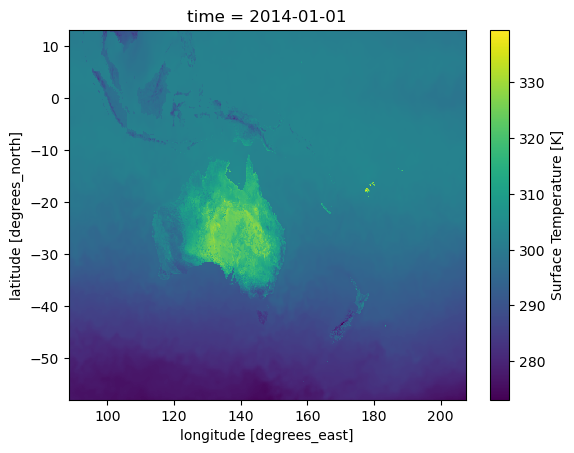

In [30]:
# Plot the first field

# Can only plot data arrays (not datasets)
da = ds_first_timestep[variable_id]
da.plot()

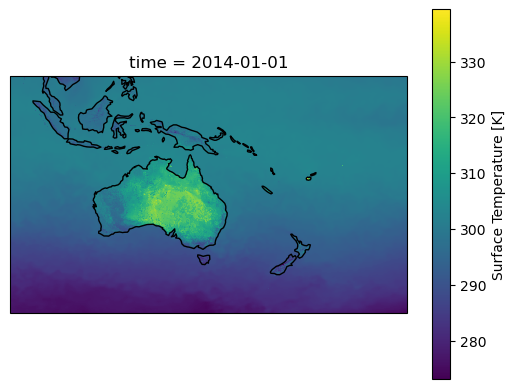

In [31]:
# Plot the first field - with coastlines!

# Can only plot data arrays (not datasets)
da = ds_first_timestep[variable_id]

# Build a cartopy projection so we can draw on the coastlines
centre_lon = da['lon'].mean().values
projection = cartopy.crs.PlateCarree(central_longitude=centre_lon)

# Now plot the field with the transform.
plot = da.plot(
    transform=cartopy.crs.PlateCarree(),
    subplot_kws={"projection": projection})

# Draw the coastlines using cartopy
plot.axes.coastlines()

### More indexing - Zoom in on Melbourne

In [32]:
# Select the Melbourne region using slice
melb_lat, melb_lon = -37.840935, 144.946457
width = 1.5

ds_melb = ds.sel(lat=slice(melb_lat - width/2, melb_lat + width/2),
                 lon=slice(melb_lon - width/2, melb_lon + width/2))

In [33]:
# Let's convert the temperature to centigrade
ds_melb[variable_id] = ds_melb[variable_id] - 273.25

# The above arithmetic will not preserve the DataArray's attributes
# So let's copy them here and update the units.
ds_melb[variable_id].attrs = ds[variable_id].attrs
ds_melb[variable_id].attrs['units'] = 'C'

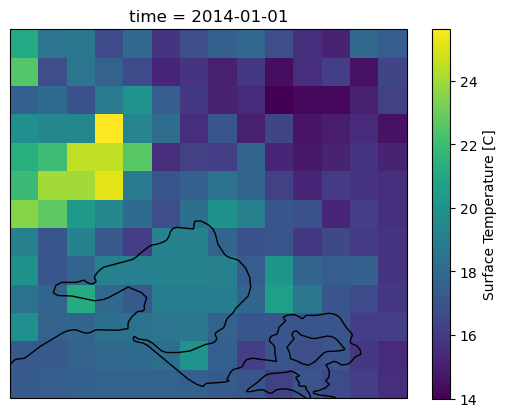

In [34]:
# Let's plot the resulting data array as we did before
# We can reuse the project we defined earlier
da = ds_melb.isel(time=0)[variable_id]

plot = da.plot(
    transform=cartopy.crs.PlateCarree(),
    subplot_kws={"projection": projection})

plot.axes.coastlines()

### Data Manipulation - Mean temperature in Melbourne during 2014

Text(0.5, 1.0, 'Mean Surface Temperature in Melbourne region (C)')

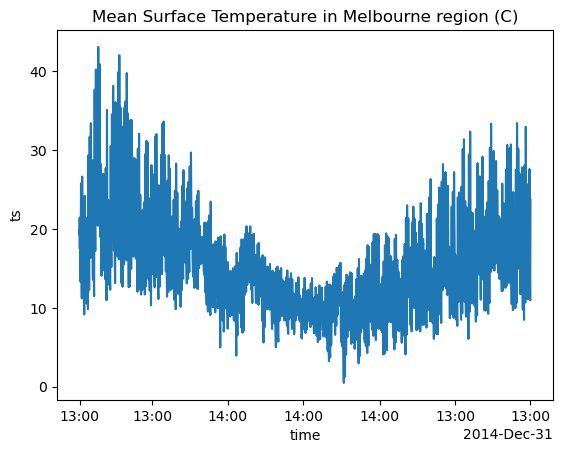

In [35]:
# Take our Melbourne dataset and caculate the mean of each spatial field then plot the result
ds_melb[variable_id].mean(dim=['lat', 'lon']).plot()

# xarray uses matplotlib to handle the plotting
# Add a custom title to the plot using the standard matplotlib command
plt.title(f"Mean {da.attrs['long_name']} in Melbourne region ({da.attrs['units']})")

### Exercises
1. Plot the average temperature in Melbourne by time-of-day
2. Plot the min and max daily temperatures in Melbourne

In [36]:
# First get time in the the local Melb timezone
# Use pandas to add the UTC timezone to 'time', convert it to Melbourne's timezone (AEDT), then remove the timezone again
time_melb = pd.to_datetime(ds_melb['time']).tz_localize('UTC').tz_convert('Australia/Melbourne').tz_localize(None)

# Replace time with time_melb
ds_melb_aedt = ds_melb.assign_coords(time_melb=("time", time_melb)).drop('time').swap_dims({'time': 'time_melb'})

# Add the attributes for time_melb so our plots below are nicer
ds_melb_aedt['time_melb'].attrs = {'standard_name': 'time_melb', 'axis': 'T', 'long_name': 'Time in AEDT'}

ds_melb_aedt

/jobfs/107505834.gadi-pbs/ipykernel_157527/1775609753.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_melb_aedt = ds_melb.assign_coords(time_melb=("time", time_melb)).drop('time').swap_dims({'time': 'time_melb'})


<xarray.Dataset>
Dimensions:    (time_melb: 8761, lat: 13, lon: 14)
Coordinates:
  * lat        (lat) float64 -38.5 -38.39 -38.28 -38.17 ... -37.4 -37.29 -37.18
  * lon        (lon) float64 144.2 144.4 144.5 144.6 ... 145.3 145.5 145.6 145.7
  * time_melb  (time_melb) datetime64[ns] 2014-01-01T11:00:00 ... 2015-01-01T...
Data variables:
    ts         (time_melb, lat, lon) float64 dask.array<chunksize=(16, 13, 6), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

#### Average temperature by time of day

Text(0, 0.5, 'Mean Surface Temperature (C)')

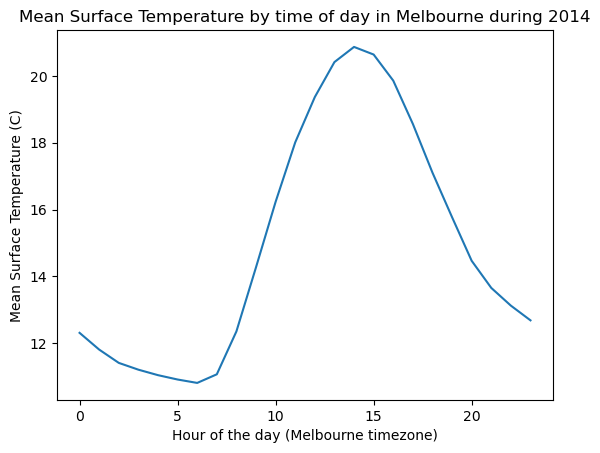

In [37]:
# Now plot the mean spatial field value, averaged for each hour of the day
ds_melb_aedt[variable_id].mean(dim=['lat', 'lon']).groupby("time_melb.hour").mean().plot()

plt.title(f'Mean {ds_melb_aedt[variable_id].attrs["long_name"]} by time of day in Melbourne during 2014')

plt.xlabel(f'Hour of the day (Melbourne timezone)')
plt.ylabel(f'Mean {ds_melb_aedt[variable_id].attrs["long_name"]} ({ds_melb_aedt[variable_id].attrs["units"]})')

#### Min and Max Temperature

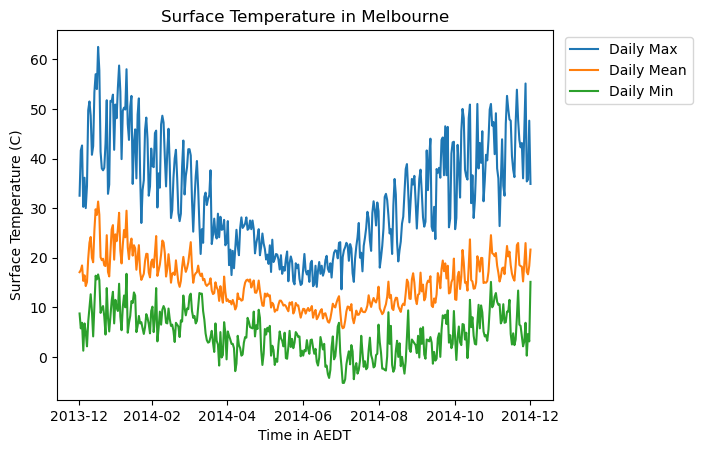

In [38]:
# Daily min and max is usually from 9am to 9am
# Resample our hourly data into daily data, and offset to 9am
dfmax=ds_melb_aedt.resample({'time_melb': '1D'}, offset='+9H').max().max(dim=['lat', 'lon'])
dfmean=ds_melb_aedt.resample({'time_melb': '1D'}, offset='+9H').mean().mean(dim=['lat', 'lon'])
dfmin=ds_melb_aedt.resample({'time_melb': '1D'}, offset='+9H').min().min(dim=['lat', 'lon'])

fig, ax = plt.subplots()
ax.plot(dfmax['time_melb'],dfmax[variable_id],label='Daily Max')
ax.plot(dfmean['time_melb'],dfmean[variable_id],label='Daily Mean')
ax.plot(dfmin['time_melb'],dfmin[variable_id],label='Daily Min')
# Let's add a legend and title, etc.
ax.legend(bbox_to_anchor=(1.01, 1.0))
ax.set_title(f'{ds_melb_aedt[variable_id].attrs["long_name"]} in Melbourne')
ax.set_xlabel(f'{ds_melb_aedt["time_melb"].attrs["long_name"]}')
ax.set_ylabel(f'{ds_melb_aedt[variable_id].attrs["long_name"]} ({ds_melb_aedt[variable_id].attrs["units"]})')
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

In [ ]:
client.close()